ШАГ 1. ЗАГРУЗКА БИБЛИОТЕК

In [22]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from dotenv import load_dotenv

ШАГ 2. ЗАПРОС ДАННЫХ ПО API ЗА ПЕРИОД 2023-03-01 -> 2023-09-01

In [23]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

ЗАПРАШИВАЕМ ВИЗИТЫ

In [24]:
visits_response = requests.get(f"{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}") #кидаем запрос методом get
visits_data = visits_response.json() #преобразуем response в json и превращаем его в data
visits_data = pd.DataFrame(visits_data) #теперь из json делаем dataframe
visits_data.head(6)

,datetime,platform,user_agent,visit_id
0,"Wed, 01 Mar 2023 10:36:22 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1de9ea66-70d3-4a1f-8735-df5ef7697fb9
1,"Wed, 01 Mar 2023 06:25:00 GMT",web,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,f149f542-e935-4870-9734-6b4501eaf614
2,"Wed, 01 Mar 2023 10:26:13 GMT",web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1
3,"Wed, 01 Mar 2023 12:33:06 GMT",web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,19322fed-157c-49c6-b16e-2d5cabeb9592
4,"Wed, 01 Mar 2023 01:38:35 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,04762a22-3c9f-40c9-9ac9-6628c4381836
5,"Wed, 01 Mar 2023 02:11:55 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,040e1e30-c9ed-4248-bc97-99a707e36d60


ЗАПРАШИВАЕМ РЕГИСТРАЦИИ

In [25]:
regs_response = requests.get(f"{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}") #кидаем запрос методом get
regs_data = regs_response.json() #преобразуем response в json и превращаем его в data
regs_data = pd.DataFrame(regs_data) #теперь из json делаем dataframe
regs_data.head(6)

,datetime,email,platform,registration_type,user_id
0,"Wed, 01 Mar 2023 07:40:13 GMT",ebyrd@example.org,web,google,2e0f6bb8-b029-4f45-a786-2b53990d37f1
1,"Wed, 01 Mar 2023 13:14:00 GMT",knightgerald@example.org,web,email,f007f97c-9d8b-48b5-af08-119bb8f6d9b6
2,"Wed, 01 Mar 2023 03:05:50 GMT",cherylthompson@example.com,web,apple,24ff46ae-32b3-4a74-8f27-7cf0b8f32f15
3,"Wed, 01 Mar 2023 00:04:47 GMT",halldavid@example.org,web,email,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60
4,"Wed, 01 Mar 2023 18:31:52 GMT",denise86@example.net,web,google,27f875fc-f8ce-4aeb-8722-0ecb283d0760
5,"Wed, 01 Mar 2023 03:54:43 GMT",wrightmelissa@example.com,web,apple,9a918a05-768e-49f5-ae48-183618bdeb7b


ШАГ 3. ОБРАБОТКА И РАСЧЕТЫ

ЧИСТИМ ВИЗИТЫ

In [26]:
#создаем новый датафрейм, копируя фрейм с api
clean_visits_data = visits_data.copy()
#перевод datetime из формата строки в формат даты 
clean_visits_data['datetime'] = pd.to_datetime(clean_visits_data['datetime'])
#сортируем данные по visits_id и дате; удаляем дубликаты по visits_id, оставляем только последний визит
clean_visits_data = clean_visits_data.sort_values(by=['visit_id', 'datetime']).drop_duplicates(subset='visit_id', keep='last')
#удаляем ботов
clean_visits_data = clean_visits_data[~clean_visits_data['user_agent'].str.contains('bot')]
#удаляем обратные кавычки
clean_visits_data['platform'] = clean_visits_data['platform'].str.strip("`")
#переводим дату в год-месяц-день
clean_visits_data['datetime'] = clean_visits_data['datetime'].dt.to_period('D').dt.start_time.dt.date
#считаем строки и создаем колонку visits
clean_visits_data = clean_visits_data.groupby(['datetime', 'platform']).size().reset_index(name='visits')
#называем расчеты старым названием, чтобы не менять весь код
visits_df = clean_visits_data
visits_df.head(6)

,datetime,platform,visits
0,2023-03-01,android,75
1,2023-03-01,ios,22
2,2023-03-01,web,279
3,2023-03-02,android,67
4,2023-03-02,ios,31
5,2023-03-02,web,515


ЧИСТИМ РЕГИСТРАЦИИ

In [27]:
#создаем новый датафрейм, копируя фрейм с api
clean_regs_data = regs_data.copy()
#удаляем дубликаты
clean_regs_data = clean_regs_data.drop_duplicates()
#заменяем nan на web
clean_regs_data['platform'] = clean_regs_data['platform'].fillna('web')
#перевод datetime из формата строки в формат даты 
clean_regs_data['datetime'] = pd.to_datetime(clean_regs_data['datetime'])
#переводим дату в год-месяц-день
clean_regs_data['datetime']=clean_regs_data['datetime'].dt.to_period('D').dt.start_time.dt.date
#считаем строки и создаем колонку registrations
clean_regs_data = clean_regs_data.groupby(['datetime', 'platform']).size().reset_index(name='registrations')
#называем расчеты старым названием, чтобы не менять весь код
regs_df = clean_regs_data
regs_df.head(6)

,datetime,platform,registrations
0,2023-03-01,android,61
1,2023-03-01,ios,18
2,2023-03-01,web,8
3,2023-03-02,android,59
4,2023-03-02,ios,24
5,2023-03-02,web,23


СЧИТАЕМ КОНВЕРСИЮ

In [28]:
# # Объединяем визиты и регистрации
# merged_df = pd.merge(visits_df, regs_df, on=['datetime', 'platform'])
# #производим расчет
# merged_df['conversion'] = (regs_df['registrations'] / visits_df['visits'] * 100)
# #записываем в файл
# merged_df.to_json('conversion.json')

# Считаем конверсию
merged_df = pd.merge(visits_df, regs_df, on=['datetime', 'platform'])
merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits'] * 100)

# Сортируем данные перед сохранением
merged_df = merged_df.sort_values(['datetime', 'platform'])

# Переименовываем колонки перед сохранением, если нужно
# merged_df = merged_df.rename(columns={'datetime': 'date'}) # раскомментируй, если в эталоне используется 'date'

# Сохраняем только нужные колонки в нужном порядке
merged_df_to_save = merged_df[['datetime', 'platform', 'visits', 'registrations', 'conversion']]

# Сохраняем в json с точными настройками
merged_df_to_save.to_json(
    'conversion.json',
    orient='records',  # каждая строка как отдельный объект
    date_format='epoch',
    date_unit='ms',
    double_precision=2  # округляем числа до 2 знаков после запятой
)


ШАГ 4. ДОБАВЛЕНИЕ ДАННЫХ ПО РЕКЛАМНЫМ КАМПАНИЯМ

In [29]:
#1. Подготовка данных о рекламных кампаниях

# Загружаем данные о рекламных кампаниях из локального файла
ads = pd.read_csv('ads.csv')

# Удаляем дубликаты
ads = ads.drop_duplicates()

# Преобразуем столбец с датой в формат datetime, чтобы оставить только дату
ads['date'] = pd.to_datetime(ads['date']).dt.to_period('D').dt.start_time.dt.date

# Сортируем данные по дате
ads = ads.sort_values(by='date')

# Заполняем пропуски в столбцах 'utm_campaign' и 'cost'
ads['utm_campaign'] = ads['utm_campaign'].fillna('none')
ads['cost'] = ads['cost'].fillna(0)

#2. Объединение с данными о конверсии

# Объединяем датафреймы по столбцу с датами
df = pd.merge(merged_df, ads, left_on='datetime', right_on='date', how='left')

# Выбираем нужные столбцы для финального датафрейма
final_df = df[['datetime', 'visits', 'registrations', 'cost', 'utm_campaign']]

# Сохраняем результат в JSON
final_df.to_json('ads.json')

# Выводим первые строки для проверки
final_df.head()

,datetime,visits,registrations,cost,utm_campaign
0,2023-03-01,75,61,212.0,advanced_algorithms_series
1,2023-03-01,22,18,212.0,advanced_algorithms_series
2,2023-03-01,279,8,212.0,advanced_algorithms_series
3,2023-03-02,67,59,252.0,advanced_algorithms_series
4,2023-03-02,31,24,252.0,advanced_algorithms_series


ШАГ 5. ВИЗУАЛИЗАЦИЯ

In [30]:
# Создаем директорию для хранения графиков, если она не существует
os.makedirs('./charts', exist_ok=True)

In [31]:
# ШАГ 5. ГРУППИРОВКА ПО НЕДЕЛЯМ

# 1. Берём наш готовый merged_df из шага 3 и группируем по неделям
merged_df['date_group'] = pd.to_datetime(merged_df['datetime']).dt.to_period('W').dt.start_time.dt.date

# 2. Группируем визиты и регистрации по неделям и платформам
weekly_stats = merged_df.groupby(['date_group', 'platform']).agg({
    'visits': 'sum',
    'registrations': 'sum'
}).reset_index()

# 3. Конверсия уже посчитана, но на всякий пересчитаем для недельных данных
weekly_stats['conversion'] = (weekly_stats['registrations'] / weekly_stats['visits'] * 100)

# 4. Если нужны общие цифры по неделям без разбивки по платформам
weekly_totals = weekly_stats.groupby('date_group').sum(numeric_only=True).reset_index()

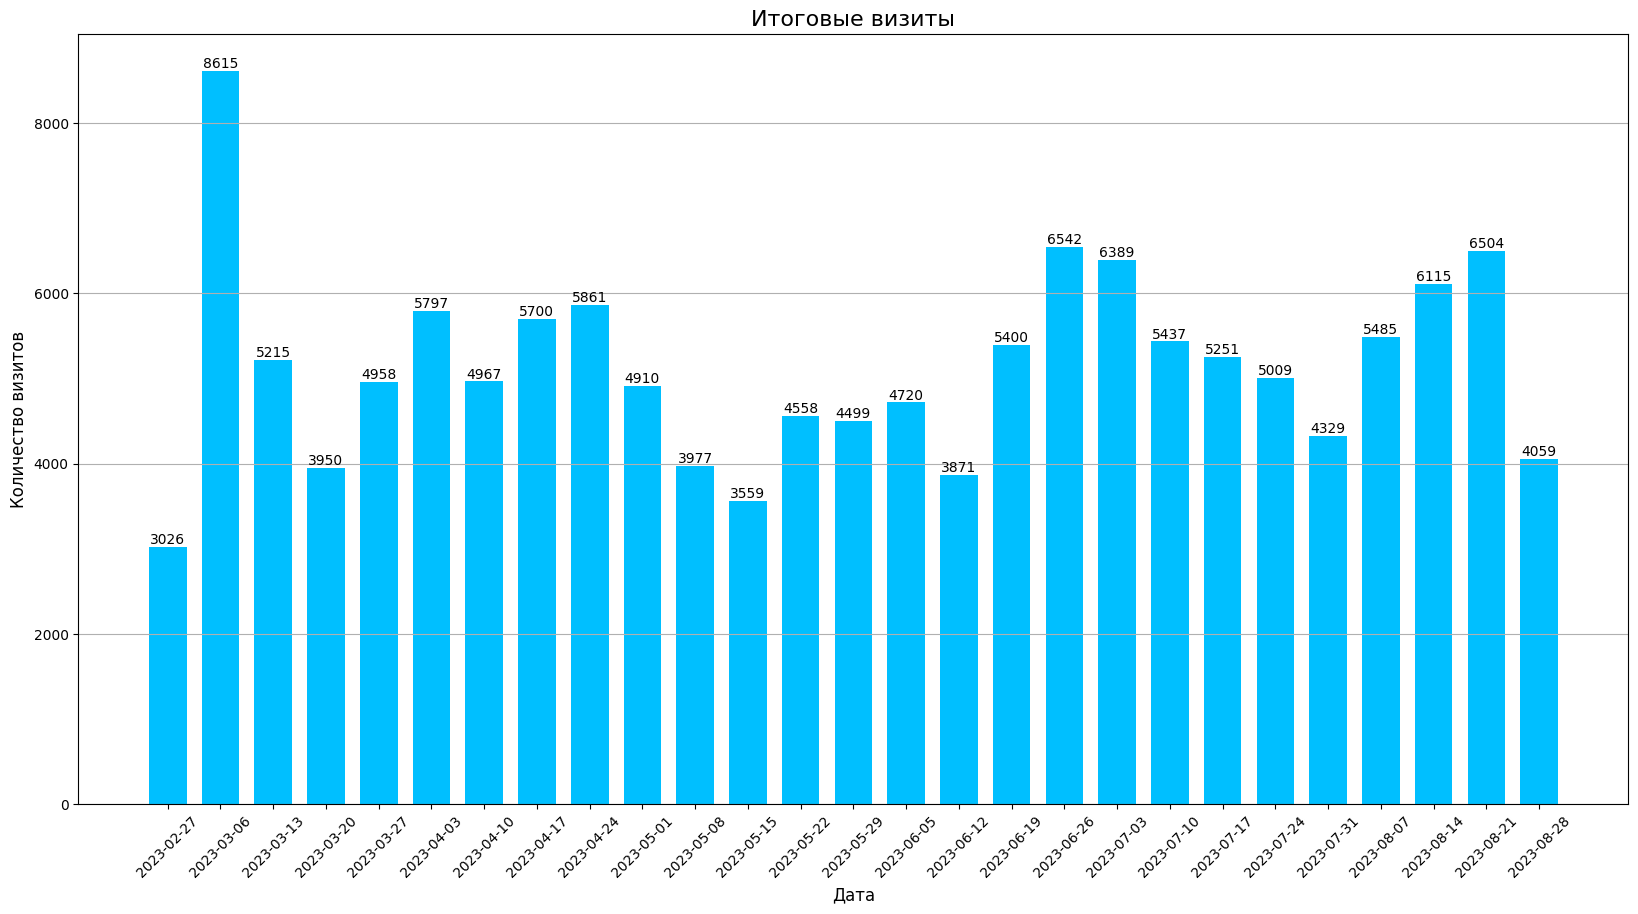

In [32]:
# Строим столбчатый график
fig, ax = plt.subplots(figsize=(20, 10))

# Используем weekly_totals вместо grouped_date
ax.bar(weekly_totals['date_group'], 
       weekly_totals['visits'], 
       color='deepskyblue', 
       width=5)

# Оформление графика
plt.title('Итоговые визиты', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество визитов', fontsize=12)
plt.xticks(weekly_totals['date_group'], rotation=45)
plt.grid(axis='y')

# Добавляем подписи для каждого столбца
for bars in ax.containers:
    ax.bar_label(bars)

# Сохраняем график и выводим его
plt.savefig('./charts/total_visits.png')
plt.show()

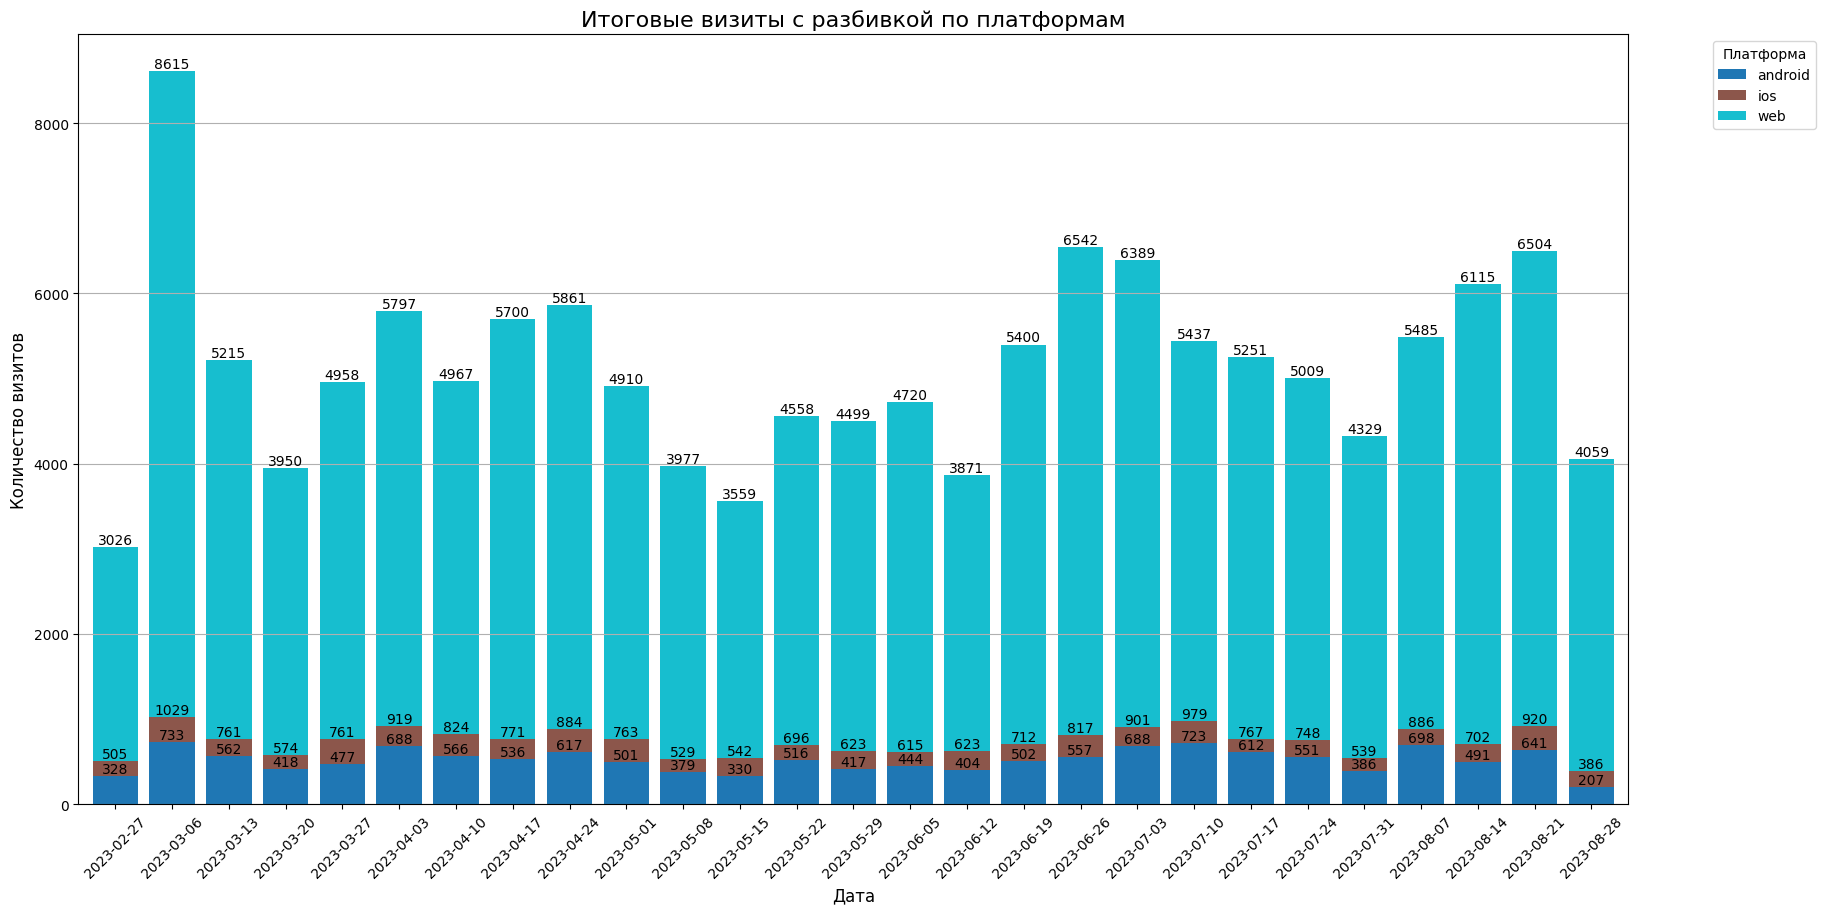

In [33]:
# График 2: Визиты по неделям и платформам, чтобы построить график
platform_visits = merged_df.groupby(['date_group', 'platform']).agg(
    visits=('visits', 'sum')
).reset_index()

# Создаем сводную таблицу для построения многосоставного столбчатого графика
pivot_visits = platform_visits.pivot(index='date_group', columns='platform', values='visits').fillna(0)

# Строим многосоставный столбчатый график
fig, ax = plt.subplots(figsize=(20, 10))
pivot_visits.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.8)

plt.title('Итоговые визиты с разбивкой по платформам', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество визитов', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')

# Добавляем подписи для каждого сегмента в столбцах
for container in ax.containers:
    ax.bar_label(container)

plt.legend(title='Платформа', bbox_to_anchor=(1.05, 1), loc='upper left')

# Сохраняем и выводим график
plt.savefig('./charts/total_visits_by_platform.png', bbox_inches='tight')
plt.show()


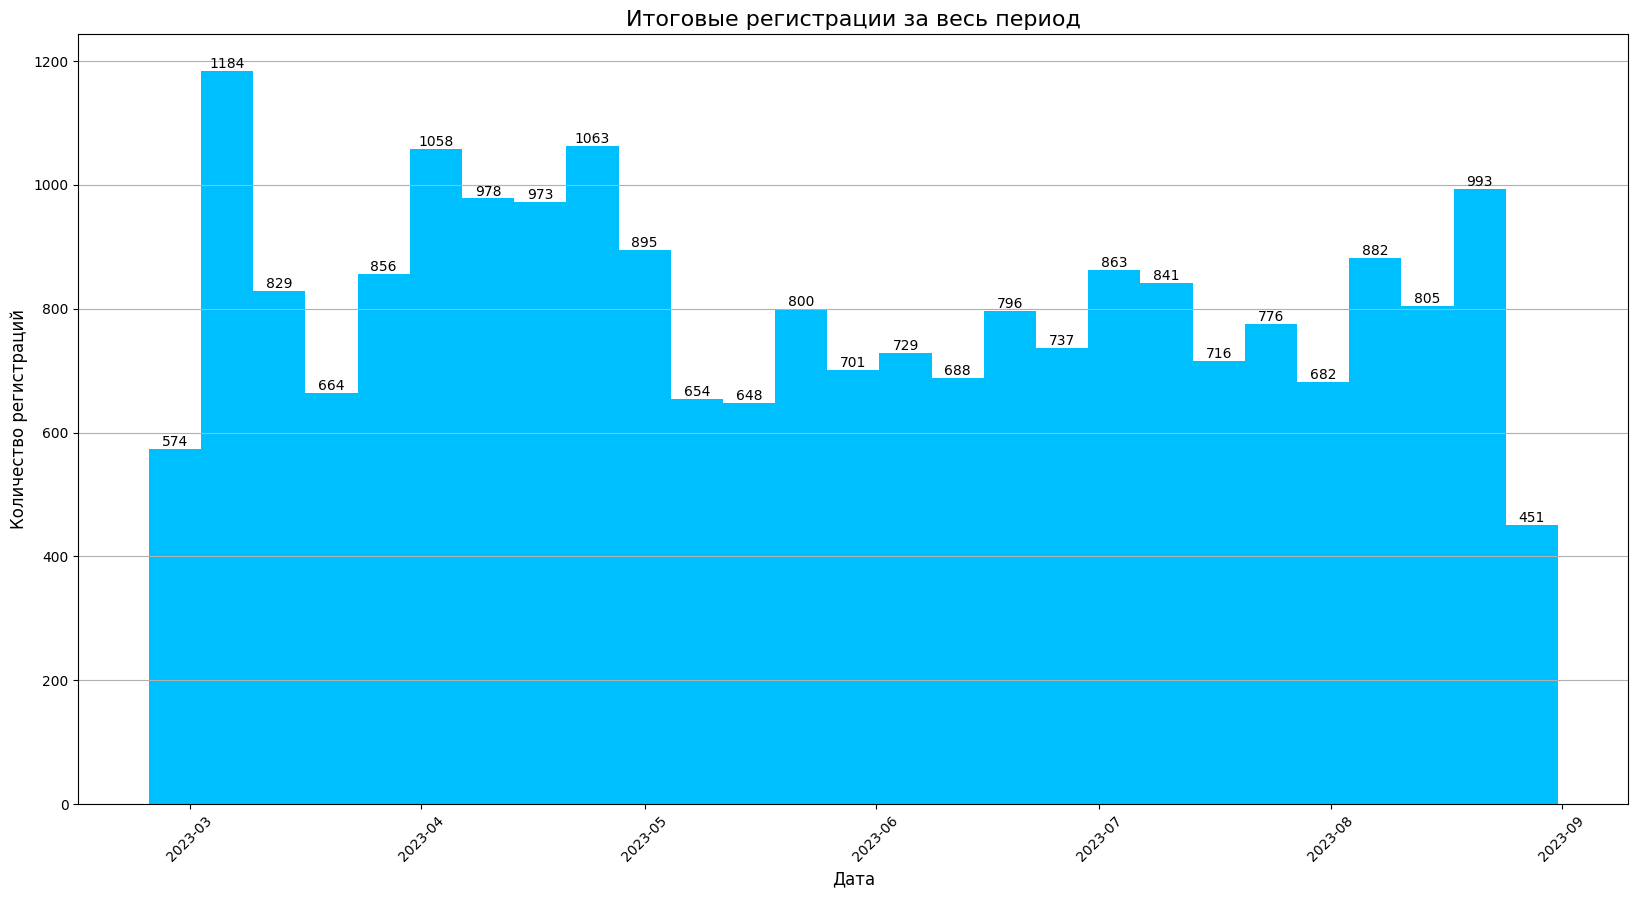

In [34]:
# График 3: Итоговые регистрации за весь период
# Строим столбчатый график для регистраций
fig, ax = plt.subplots(figsize=(20, 10))

# Используем готовые данные из weekly_totals
ax.bar(weekly_totals['date_group'], 
       weekly_totals['registrations'], 
       color='deepskyblue', 
       width=7)

plt.title('Итоговые регистрации за весь период', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество регистраций', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')

# Добавляем подписи для каждого столбца
for bars in ax.containers:
    ax.bar_label(bars)

# Сохраняем и выводим график
plt.savefig('./charts/total_registrations.png', bbox_inches='tight')
plt.show()

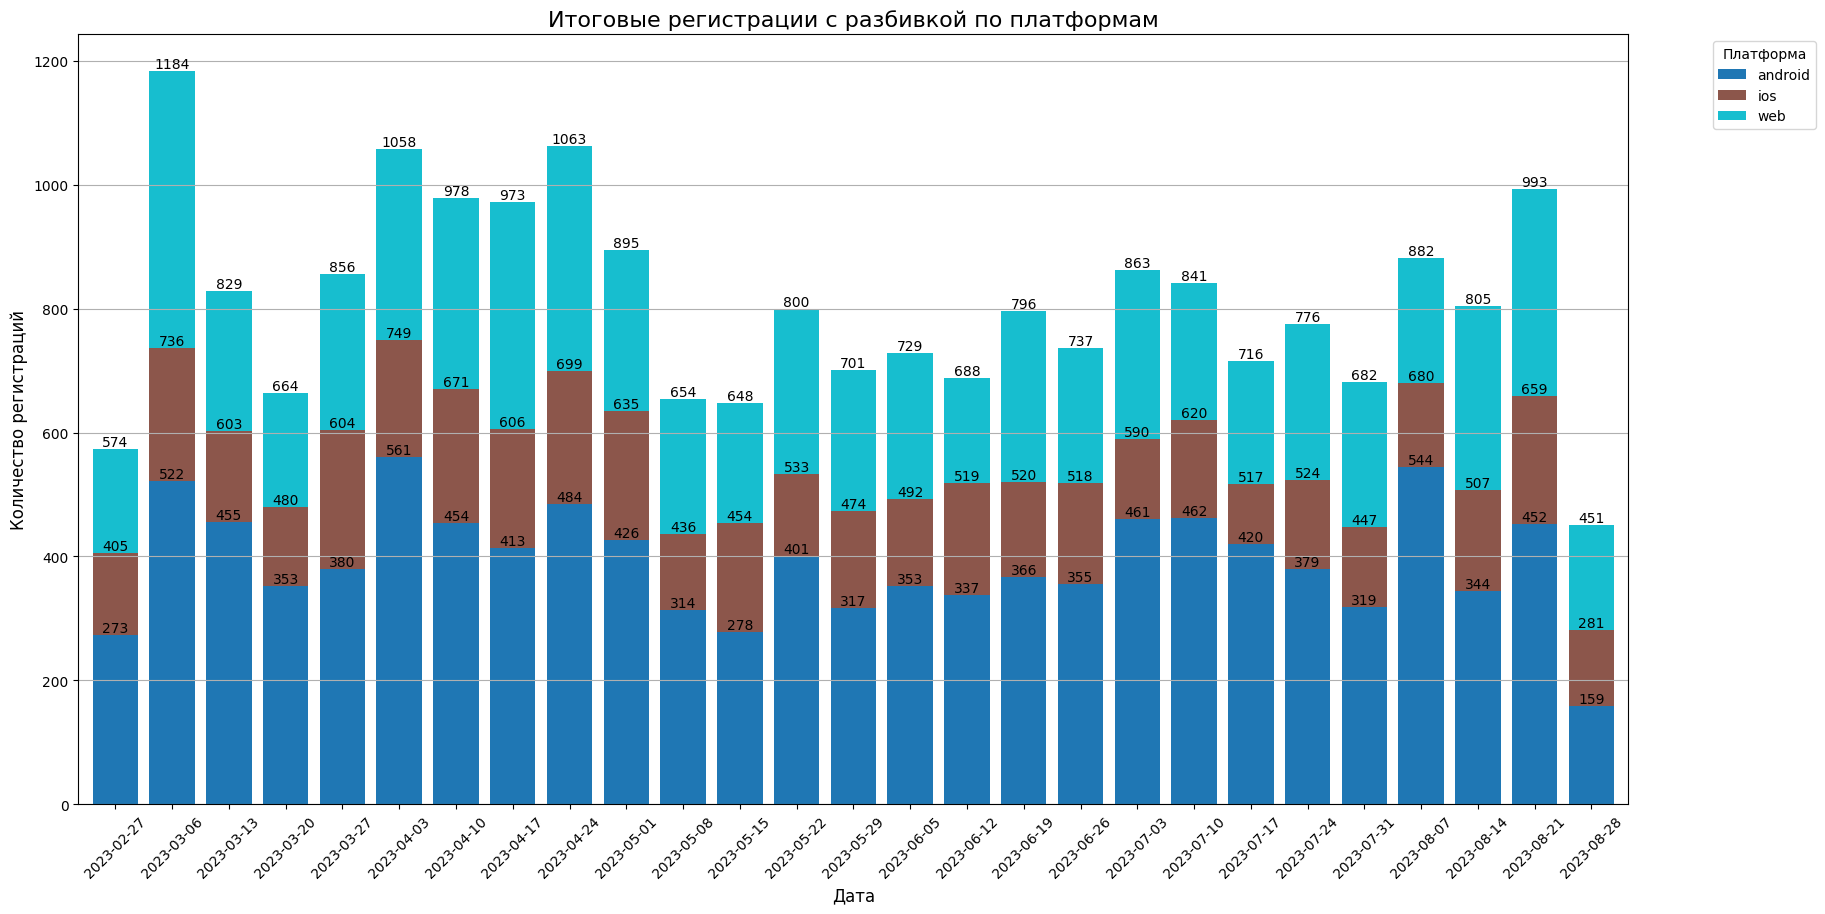

In [35]:
# График 4: Итоговые регистрации с разбивкой по платформам
# Создаем сводную таблицу из weekly_stats
pivot_regs = weekly_stats.pivot(
    index='date_group',
    columns='platform',
    values='registrations'
).fillna(0)

# Строим многосоставный столбчатый график
fig, ax = plt.subplots(figsize=(20, 10))
pivot_regs.plot(kind='bar', 
                stacked=True, 
                ax=ax, 
                colormap='tab10', 
                width=0.8)

plt.title('Итоговые регистрации с разбивкой по платформам', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество регистраций', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')

# Добавляем подписи на каждый сегмент столбца
for container in ax.containers:
    ax.bar_label(container)

plt.legend(title='Платформа', bbox_to_anchor=(1.05, 1), loc='upper left')

# Сохраняем и выводим график
plt.savefig('./charts/registrations_by_platform.png', bbox_inches='tight')
plt.show()

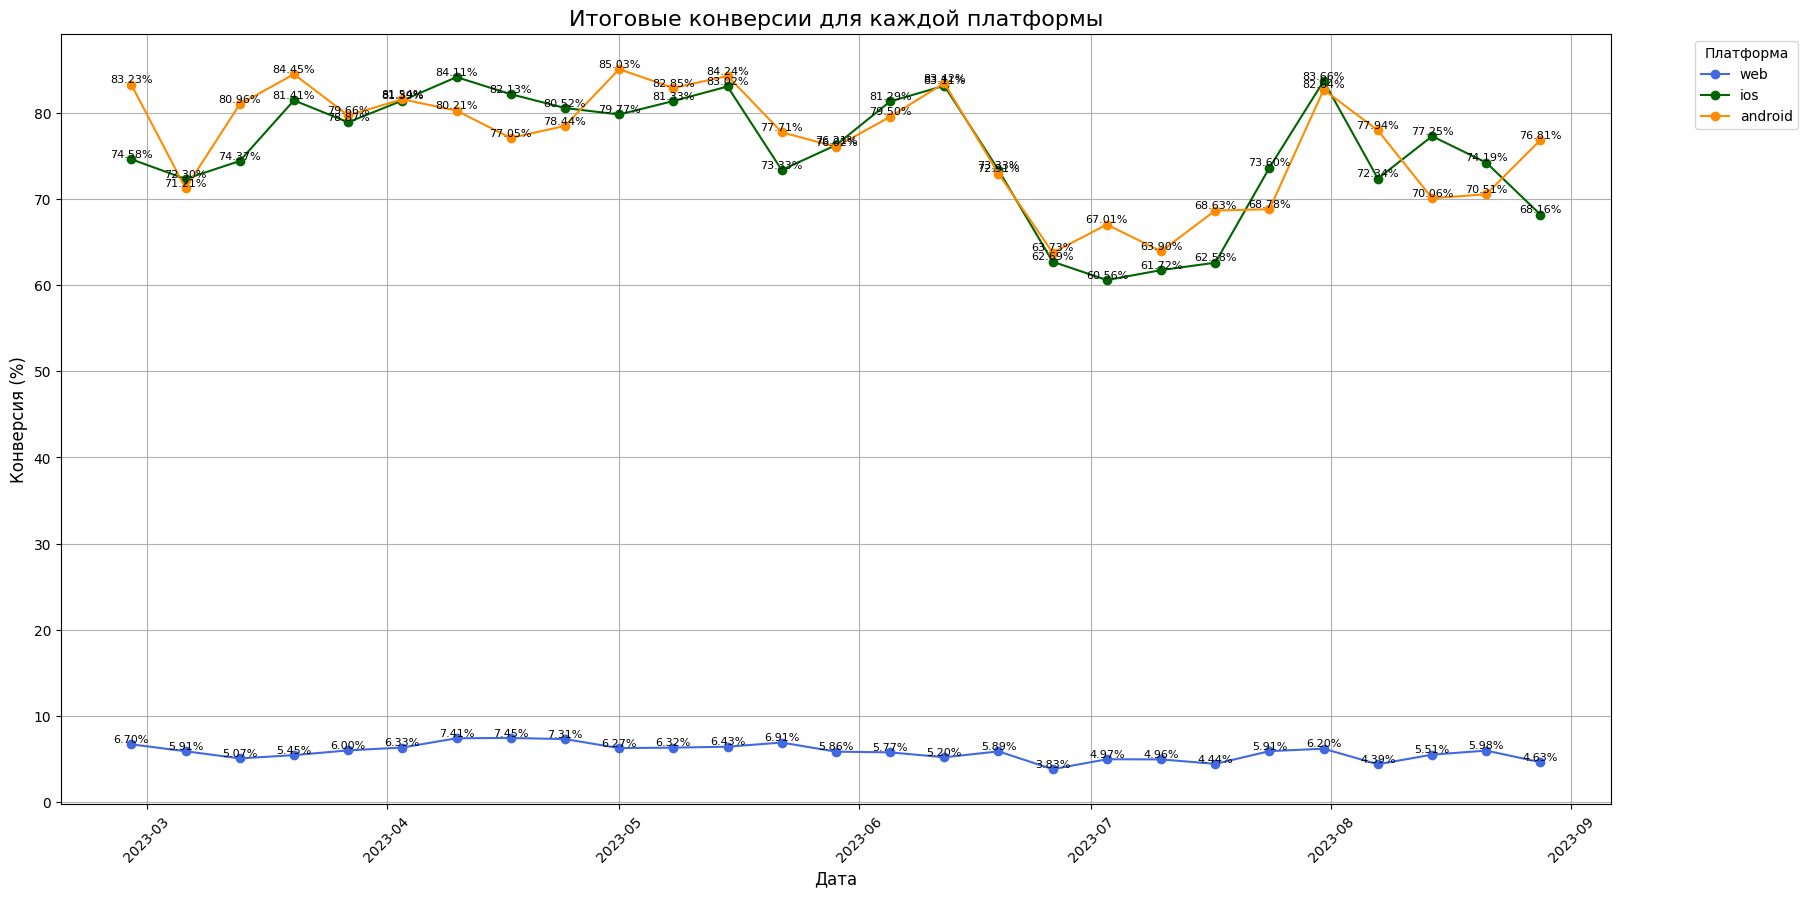

In [36]:
# График 5.1: Итоговая конверсия по платформам (1 график на одном холсте)

# Определяем платформы
platforms = ['web', 'ios', 'android']

# Цвета для каждой платформы
colors = {'web': 'royalblue', 'ios': 'darkgreen', 'android': 'darkorange'}

# Строим один график с тремя линиями для каждой платформы
fig, ax = plt.subplots(figsize=(20, 10))

# Строим линии для каждой платформы
for platform in platforms:
    # Фильтруем данные для текущей платформы
    platform_data = weekly_stats[weekly_stats['platform'] == platform]
    
    # Строим линию
    ax.plot(platform_data['date_group'], 
            platform_data['conversion'], 
            marker='o', 
            linestyle='-', 
            label=platform, 
            color=colors[platform])
    
    # Добавляем подписи для каждой точки
    for x, y in zip(platform_data['date_group'], platform_data['conversion']):
        if y > 0:
            ax.text(x, y, f'{y:.2f}%', ha='center', va='bottom', fontsize=8)

plt.title('Итоговые конверсии для каждой платформы', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Конверсия (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Платформа', bbox_to_anchor=(1.05, 1), loc='upper left')

# Сохраняем и выводим график
plt.savefig('./charts/combined_platform_conversion.png', bbox_inches='tight')
plt.show()

In [37]:
#График 5.2: Итоговая конверсия по платформам (3 графика на одном холсте) (если потребуется)
# Определяем платформы и цвета
# platforms = ['web', 'ios', 'android']
# colors = {'web': 'royalblue', 'ios': 'darkgreen', 'android': 'darkorange'}

# # Строим 3 графика на одном рисунке
# fig, axs = plt.subplots(3, 1, figsize=(20, 15), sharex=True)

# # Строим график для каждой платформы
# for ax, platform in zip(axs, platforms):
#     # Фильтруем данные для текущей платформы
#     platform_data = weekly_stats[weekly_stats['platform'] == platform]
   
#     # Строим линию
#     ax.plot(platform_data['date_group'], 
#             platform_data['conversion'], 
#             marker='o', 
#             linestyle='-', 
#             color=colors[platform])
   
#     # Добавляем подписи для каждой точки
#     for x, y in zip(platform_data['date_group'], platform_data['conversion']):
#         if y > 0:
#             ax.text(x, y, f'{y:.2f}%', ha='center', va='bottom', fontsize=10)
           
#     ax.set_title(f'Итоговые конверсии для {platform}', fontsize=16)
#     ax.set_xlabel('Дата', fontsize=12)
#     ax.set_ylabel('Конверсия (%)', fontsize=12)
#     ax.grid(True)

# plt.xticks(rotation=45)
# plt.tight_layout()

# # Сохраняем и выводим график
# plt.savefig('./charts/combined_conversion.png', bbox_inches='tight')
# plt.show()

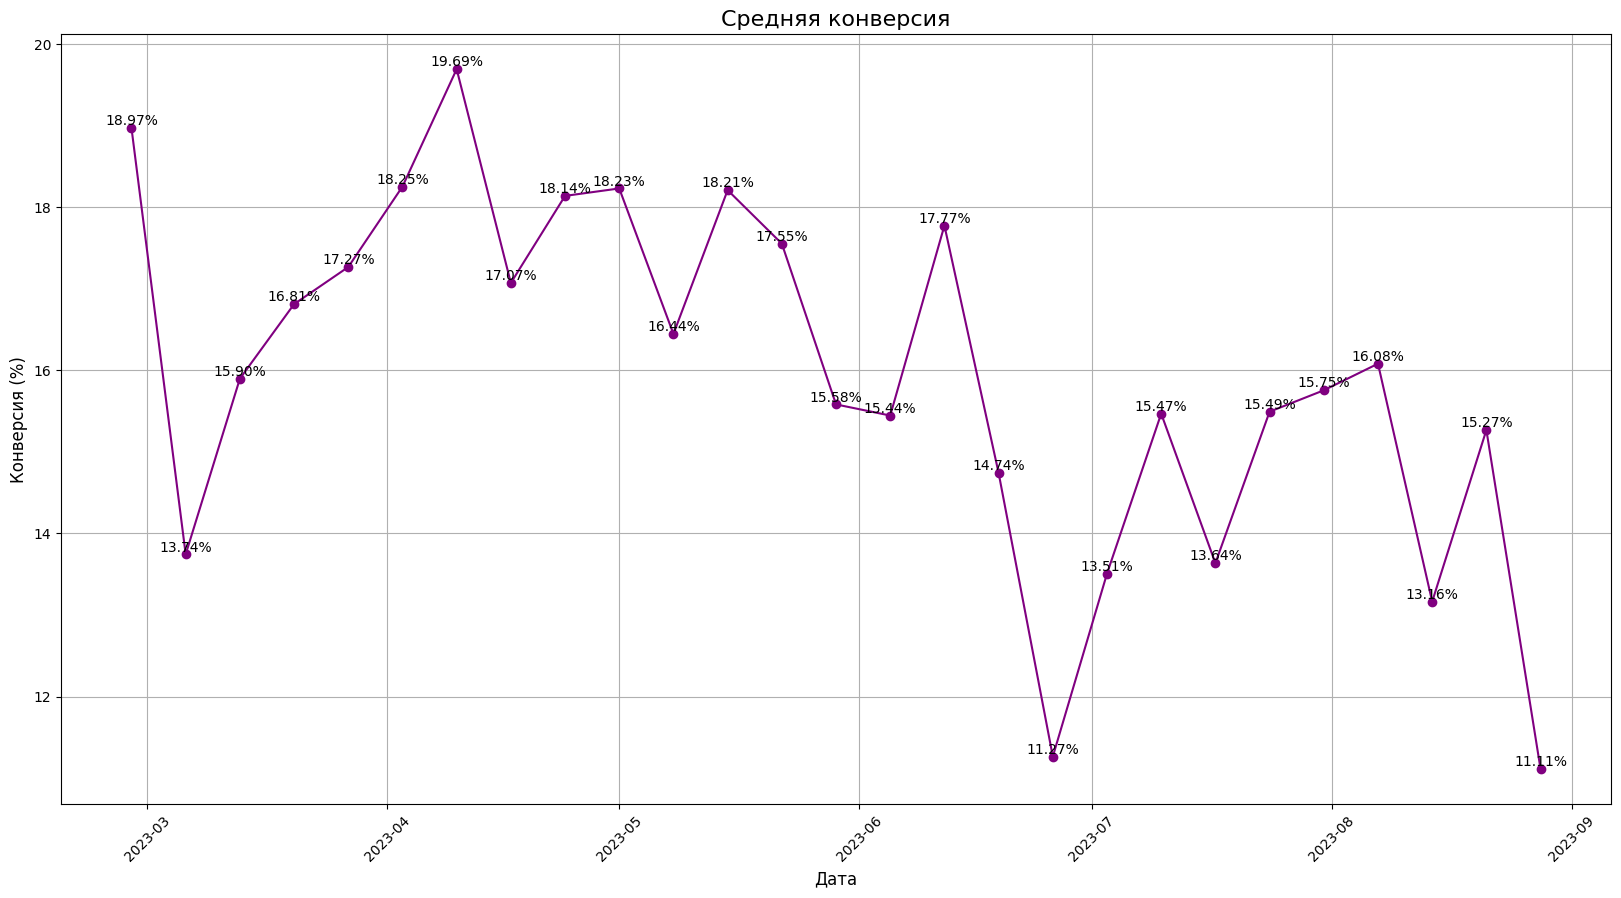

In [38]:
# График 6: Средняя (итоговая) конверсия за весь период
# Правильно считаем общую конверсию
average_conversion = weekly_stats.groupby('date_group').agg({
    'visits': 'sum',
    'registrations': 'sum'
}).reset_index()

# Считаем конверсию ПОСЛЕ суммирования
average_conversion['conversion'] = (average_conversion['registrations'] / average_conversion['visits'] * 100)

# Строим график средней конверсии
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(average_conversion['date_group'], 
        average_conversion['conversion'], 
        marker='o', 
        linestyle='-', 
        color='purple')

plt.title('Средняя конверсия', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Конверсия (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Добавляем подписи на каждую точку
for x, y in zip(average_conversion['date_group'], average_conversion['conversion']):
    if y > 0:
        ax.text(x, y, f'{y:.2f}%', ha='center', va='bottom', fontsize=10)

# Сохраняем и выводим график
plt.savefig('./charts/average_conversion.png', bbox_inches='tight')
plt.show()

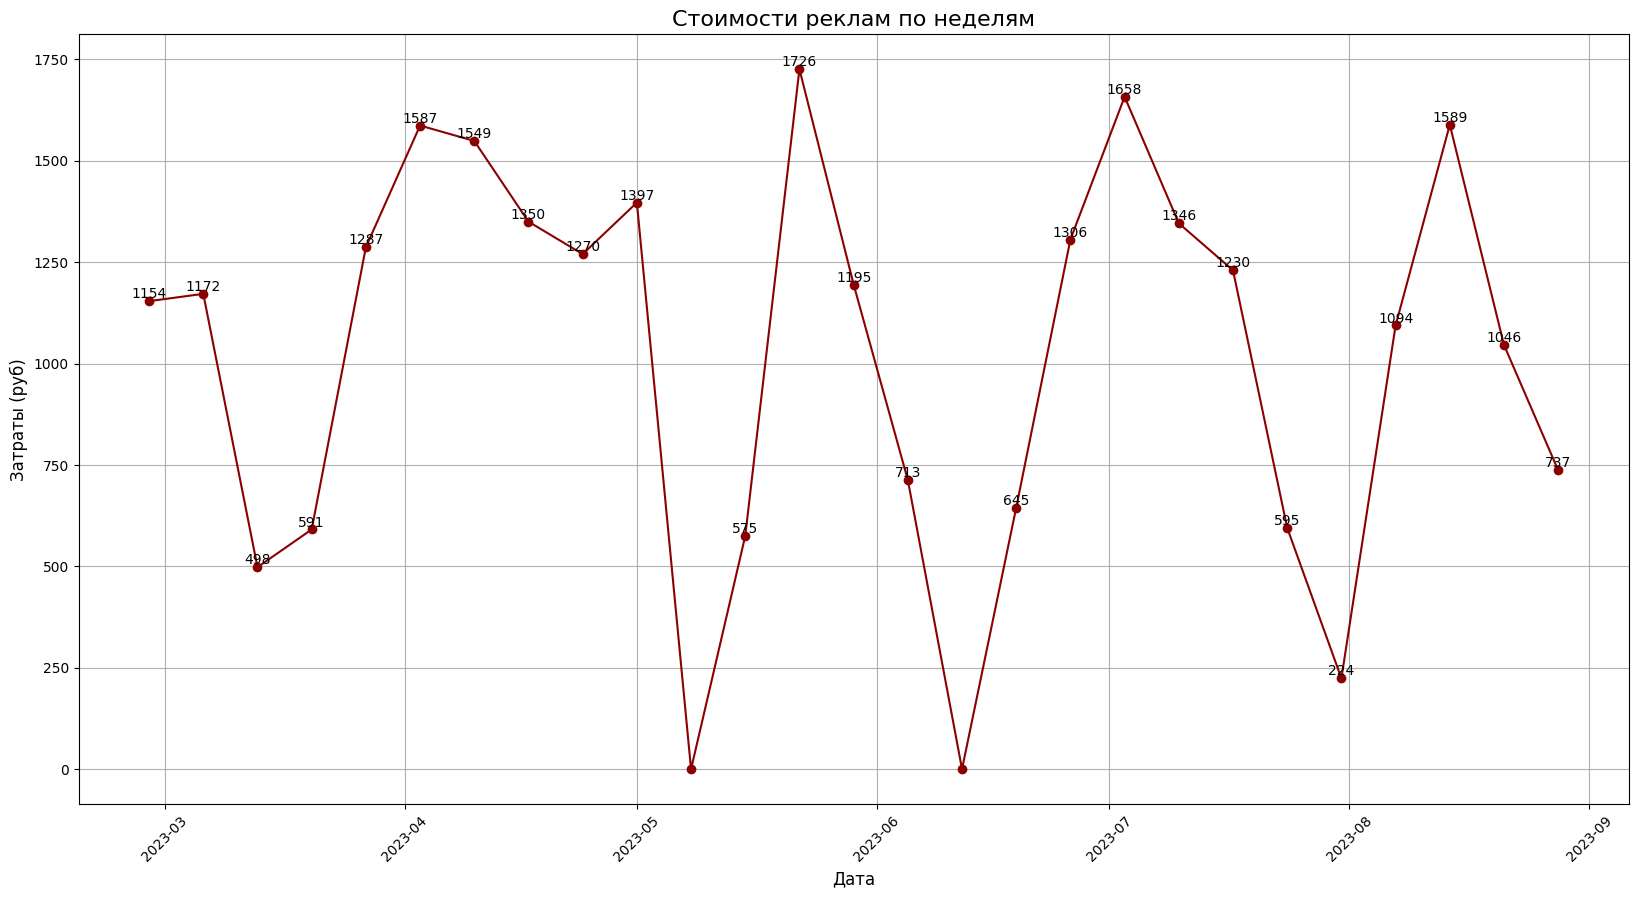

In [39]:
#График 7.1: Стоимости рекламы по неделям
# Сначала возьмем уникальные значения затрат по дням
unique_costs = final_df.drop_duplicates(['datetime', 'cost'])[['datetime', 'cost']]

# Потом сгруппируем по неделям
weekly_ads_cost = unique_costs.groupby(
    pd.to_datetime(unique_costs['datetime']).dt.to_period('W').dt.start_time
).agg({
    'cost': 'sum'
}).reset_index()

weekly_ads_cost.columns = ['datetime', 'cost']

# Строим график стоимости реклам (линия с точками)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(weekly_ads_cost['datetime'], 
        weekly_ads_cost['cost'], 
        marker='o', 
        linestyle='-', 
        color='darkred')

plt.title('Стоимости реклам по неделям', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Затраты (руб)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Добавляем подписи для точек с ненулевыми значениями
for x, y in zip(weekly_ads_cost['datetime'], weekly_ads_cost['cost']):
    if y > 0:
        ax.text(x, y, f'{y:.0f}', ha='center', va='bottom', fontsize=10)

# Сохраняем и выводим график
plt.savefig('./charts/ads_cost.png', bbox_inches='tight')
plt.show()

In [40]:
# График 7.2: Стоимости рекламы по дням (если потребуется)
# Получаем уникальные значения затрат по дням из final_df
# daily_ads_cost = final_df.drop_duplicates(['datetime', 'cost'])[['datetime', 'cost']]

# # Фильтруем только дни с ненулевыми затратами
# daily_ads_cost = daily_ads_cost[daily_ads_cost['cost'] > 0]

# # Строим график стоимости реклам (линия с точками)
# fig, ax = plt.subplots(figsize=(20, 10))
# ax.plot(daily_ads_cost['datetime'], 
#         daily_ads_cost['cost'], 
#         marker='o', 
#         linestyle='-', 
#         color='darkred')

# plt.title('Стоимости реклам по дням', fontsize=16)
# plt.xlabel('Дата', fontsize=12)
# plt.ylabel('Затраты (руб)', fontsize=12)

# # Устанавливаем метки на оси X с форматом "Месяц-День"
# ax.set_xticks(daily_ads_cost['datetime'])
# ax.set_xticklabels(
#     [x.strftime('%m-%d') for x in daily_ads_cost['datetime']],
#     rotation=45, 
#     ha='right', 
#     fontsize=10
# )

# plt.grid(True)

# # Добавляем подписи для точек с ненулевыми значениями
# for x, y in zip(daily_ads_cost['datetime'], daily_ads_cost['cost']):
#     ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=8)

# # Сохраняем и выводим график
# plt.savefig('./charts/daily_ads_cost_improved.png', bbox_inches='tight')
# plt.show()

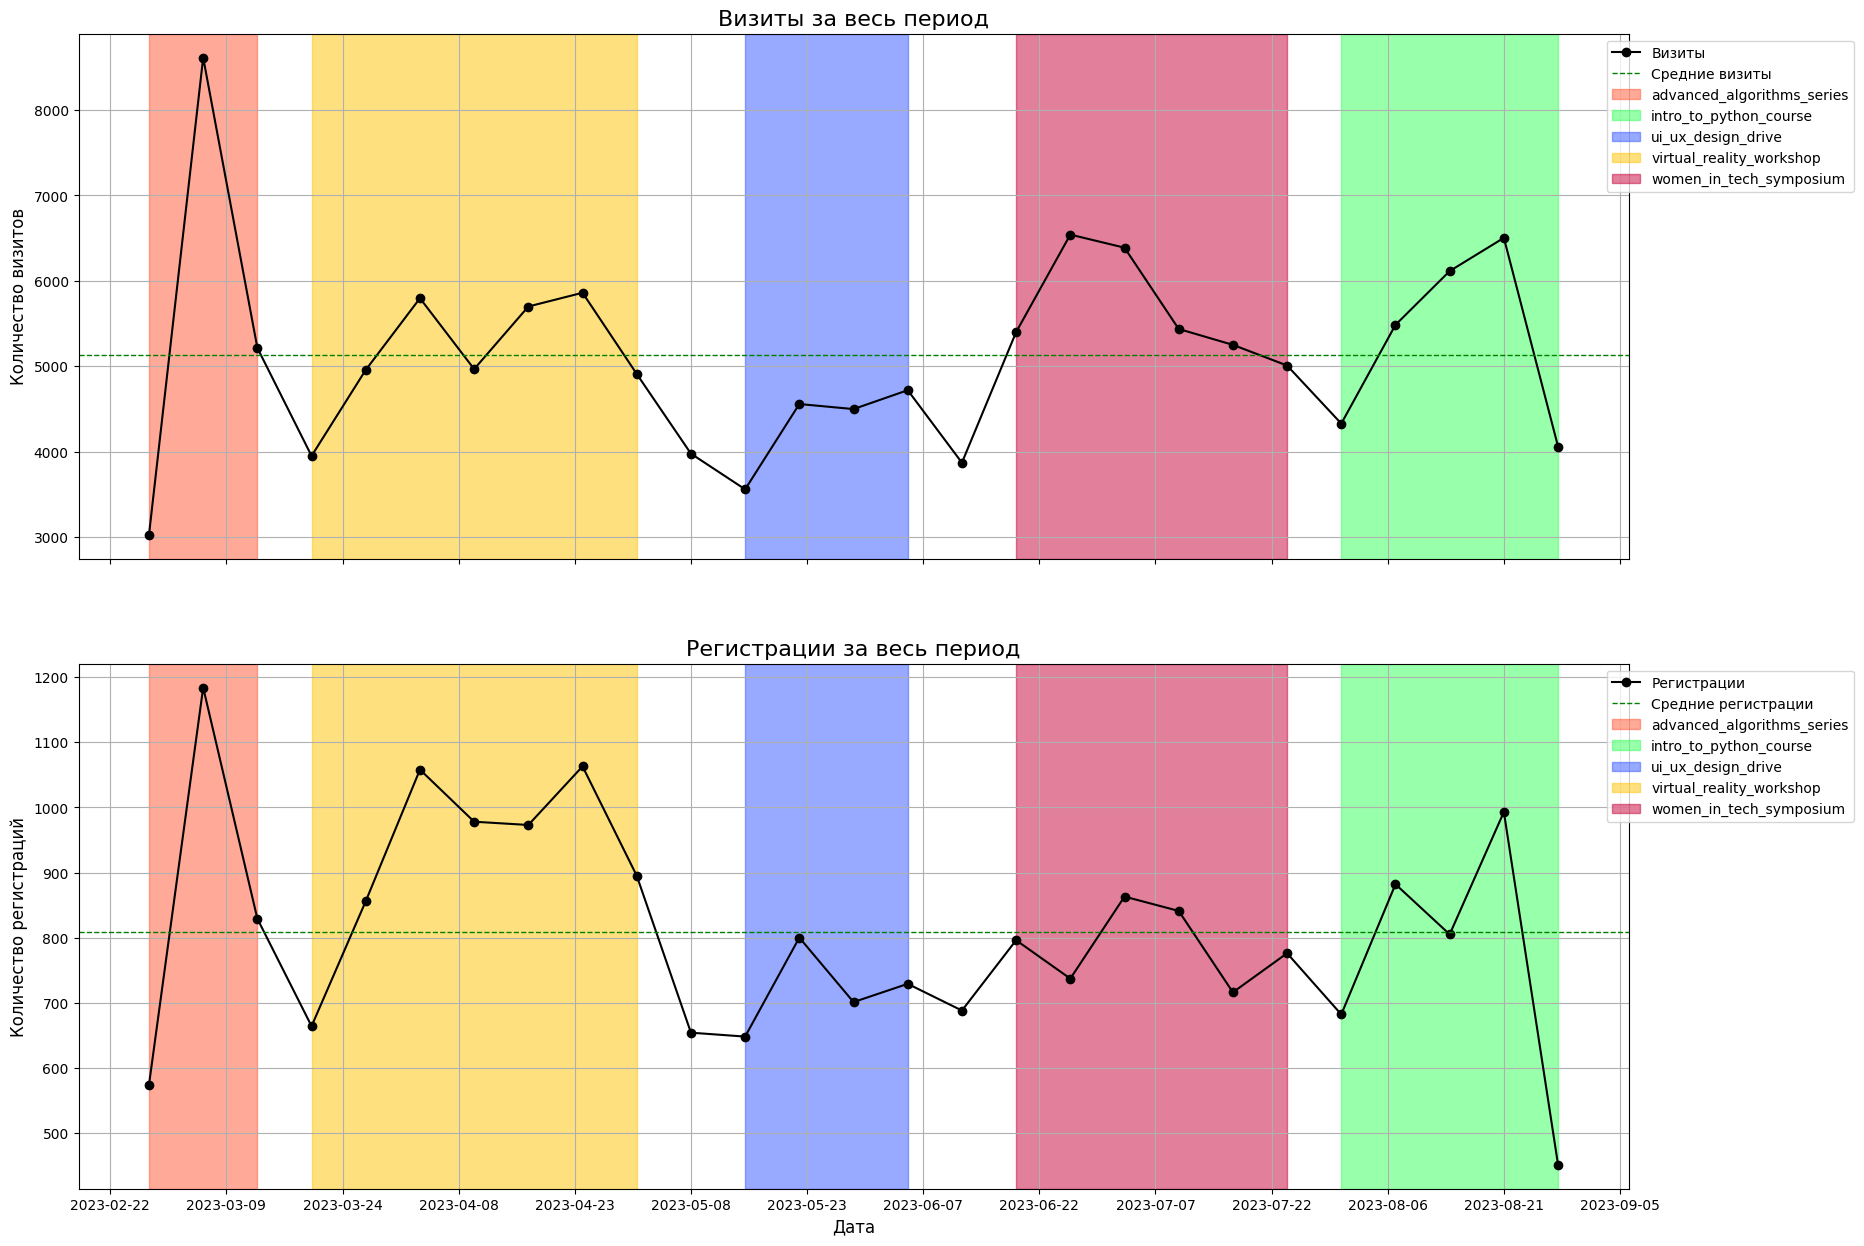

In [41]:
# График 8: Визиты и регистрации с цветовым выделением рекламных кампаний

# Группируем данные по неделям из final_df
weekly_stats = final_df.drop_duplicates(['datetime', 'visits', 'registrations']).groupby(
    pd.to_datetime(final_df['datetime']).dt.to_period('W').dt.start_time
).agg({
    'visits': 'sum',
    'registrations': 'sum',
    'utm_campaign': 'first'  # берем первую кампанию недели
}).reset_index()

# Получаем периоды рекламных кампаний по неделям
ads_campaigns = final_df.drop_duplicates(['datetime', 'utm_campaign']).groupby('utm_campaign').agg(
    DATE_BEGIN=('datetime', lambda x: pd.to_datetime(x).dt.to_period('W').dt.start_time.min()),
    DATE_END=('datetime', lambda x: pd.to_datetime(x).dt.to_period('W').dt.start_time.max())
).reset_index()

# Функция для выделения областей рекламных кампаний
def highlight_campaigns(ax, campaigns, colors):
    for i, (_, campaign) in enumerate(campaigns.iterrows()):
        ax.axvspan(campaign['DATE_BEGIN'], campaign['DATE_END'], 
                   color=colors[i % len(colors)], alpha=0.5, label=campaign['utm_campaign'])

# Рассчитываем средние значения
mean_visits = weekly_stats['visits'].mean()
mean_registrations = weekly_stats['registrations'].mean()

# Определяем цвета для кампаний
campaign_colors = ['#FF5733', '#33FF57', '#3357FF', '#FFC300', '#C70039']

# Строим график
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15), sharex=True)

# График визитов
ax1.plot(weekly_stats['datetime'], weekly_stats['visits'], 
         marker='o', linestyle='-', color='black', label='Визиты')
ax1.axhline(mean_visits, color='green', linestyle='--', linewidth=1, label='Средние визиты')
highlight_campaigns(ax1, ads_campaigns, campaign_colors)
ax1.set_title('Визиты за весь период', fontsize=16)
ax1.set_ylabel('Количество визитов', fontsize=12)
ax1.grid(True)
ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# График регистраций
ax2.plot(weekly_stats['datetime'], weekly_stats['registrations'], 
         marker='o', linestyle='-', color='black', label='Регистрации')
ax2.axhline(mean_registrations, color='green', linestyle='--', linewidth=1, label='Средние регистрации')
highlight_campaigns(ax2, ads_campaigns, campaign_colors)
ax2.set_title('Регистрации за весь период', fontsize=16)
ax2.set_xlabel('Дата', fontsize=12)
ax2.set_ylabel('Количество регистраций', fontsize=12)
ax2.grid(True)
ax2.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Ограничиваем количество меток на оси X
locator = plt.MaxNLocator(nbins=15)
ax2.xaxis.set_major_locator(locator)

# Сохраняем и выводим график
plt.savefig('./charts/visits_regs_with_campaigns_improved.png', bbox_inches='tight')
plt.show()